In [3]:
import sys

# New Section

In [4]:
# To add your own Drive Run this cell.
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# Please append your own directory after ‘/content/drive/My Drive/'
# where you have nutil.py and adult_subsample.csv
### ========== TODO : START ========== ###
sys.path += ['/content/drive/My Drive/cm146-2023-homeworks/PS1'] 
sys.path += ['/content/drive/My Drive'] 

### ========== TODO : END ========== ###


In [6]:
from nutil import *

In [7]:
# Use only the provided packages!
import math
import csv

from collections import Counter

from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedShuffleSplit
import numpy as np
np.warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning) 

In [8]:
######################################################################
# Immutatble classes
######################################################################

class Classifier(object) :
    """
    Classifier interface.
    """

    def fit(self, X, y):
        raise NotImplementedError()

    def predict(self, X):
        raise NotImplementedError()


class MajorityVoteClassifier(Classifier) :

    def __init__(self) :
        """
        A classifier that always predicts the majority class.

        Attributes
        --------------------
            prediction_ -- majority class
        """
        self.prediction_ = None

    def fit(self, X, y) :
        """
        Build a majority vote classifier from the training set (X, y).

        Parameters
        --------------------
            X    -- numpy array of shape (n,d), samples
            y    -- numpy array of shape (n,), target classes

        Returns
        --------------------
            self -- an instance of self
        """
        majority_val = Counter(y).most_common(1)[0][0]
        self.prediction_ = majority_val
        return self

    def predict(self, X) :
        """
        Predict class values.

        Parameters
        --------------------
            X    -- numpy array of shape (n,d), samples

        Returns
        --------------------
            y    -- numpy array of shape (n,), predicted classes
        """
        if self.prediction_ is None :
            raise Exception("Classifier not initialized. Perform a fit first.")

        n,d = X.shape
        y = [self.prediction_] * n
        return y



In [9]:
######################################################################
# Mutatble classes
######################################################################

class RandomClassifier(Classifier) :

    def __init__(self) :
        """
        A classifier that predicts according to the distribution of the classes.

        Attributes
        --------------------
            probabilities_ -- class distribution dict (key = class, val = probability of class)
        """
        self.probabilities_ = {}

    def fit(self, X, y) :
        """
        Build a random classifier from the training set (X, y).

        Parameters
        --------------------
            X    -- numpy array of shape (n,d), samples
            y    -- numpy array of shape (n,), target classes

        Returns
        --------------------
            self -- an instance of self
        """

        ### ========== TODO : START ========== ###
        # part b: set self.probabilities_ according to the training set

        #use np.unique to identify # of unique classes in y.
        unique_cl, count = np.unique(y,return_counts = True)

        #Create list of tuples of class and probabilities to create dictionary
        dict_cl = dict(zip(unique_cl, count/len(y)))
        
        self.probabilities_ = dict_cl

        ### ========== TODO : END ========== ###

        return self

    def predict(self, X, seed=1234) :
        """
        Predict class values.

        Parameters
        --------------------
            X    -- numpy array of shape (n,d), samples
            seed -- integer, random seed

        Returns
        --------------------
            y    -- numpy array of shape (n,), predicted classes
        """
        if self.probabilities_ is None :
            raise Exception("Classifier not initialized. Perform a fit first.")
        np.random.seed(seed)

        ### ========== TODO : START ========== ###
        # part b: predict the class for each test example
        # hint: use np.random.choice (be careful of the parameters)

        n, d = X.shape

        num_classes = len(self.probabilities_.keys())
        probabilities = list(self.probabilities_.values())

        y = np.random.choice(num_classes,X.shape[0],p = probabilities)

        
        ### ========== TODO : END ========== ###

        return y


In [10]:
######################################################################
# Immutatble functions
######################################################################

def plot_histograms(X, y, Xnames, yname) :
    n,d = X.shape  # n = number of examples, d =  number of features
    fig = plt.figure(figsize=(20,15))
    ncol = 3
    nrow = d // ncol + 1
    for i in range(d) :
        fig.add_subplot (nrow,ncol,i+1)
        data, bins, align, labels = plot_histogram(X[:,i], y, Xname=Xnames[i], yname=yname, show = False)
        n, bins, patches = plt.hist(data, bins=bins, align=align, alpha=0.5, label=labels)
        plt.xlabel(Xnames[i])
        plt.ylabel('Frequency')
        plt.legend() #plt.legend(loc='upper left')

    plt.savefig ('histograms.pdf')


def plot_histogram(X, y, Xname, yname, show = True) :
    """
    Plots histogram of values in X grouped by y.

    Parameters
    --------------------
        X     -- numpy array of shape (n,d), feature values
        y     -- numpy array of shape (n,), target classes
        Xname -- string, name of feature
        yname -- string, name of target
    """

    # set up data for plotting
    targets = sorted(set(y))
    data = []; labels = []
    for target in targets :
        features = [X[i] for i in range(len(y)) if y[i] == target]
        data.append(features)
        labels.append('%s = %s' % (yname, target))

    # set up histogram bins
    features = set(X)
    nfeatures = len(features)
    test_range = list(range(int(math.floor(min(features))), int(math.ceil(max(features)))+1))
    if nfeatures < 10 and sorted(features) == test_range:
        bins = test_range + [test_range[-1] + 1] # add last bin
        align = 'left'
    else :
        bins = 10
        align = 'mid'

    # plot
    if show == True:
        plt.figure()
        n, bins, patches = plt.hist(data, bins=bins, align=align, alpha=0.5, label=labels)
        plt.xlabel(Xname)
        plt.ylabel('Frequency')
        plt.legend() #plt.legend(loc='upper left')
        plt.show()

    return data, bins, align, labels


In [11]:
######################################################################
# Mutatble functions
######################################################################

def error(clf, X, y, ntrials=100, test_size=0.2) :
    """
    Computes the classifier error over a random split of the data,
    averaged over ntrials runs.

    Parameters
    --------------------
        clf         -- classifier
        X           -- numpy array of shape (n,d), features values
        y           -- numpy array of shape (n,), target classes
        ntrials     -- integer, number of trials

    Returns
    --------------------
        train_error -- float, training error
        test_error  -- float, test error
        f1_score    -- float, test "micro" averaged f1 score
    """

    ### ========== TODO : START ========== ###
    # compute cross-validation error using StratifiedShuffleSplit over ntrials
    
    #Intiiliaze errors
    train_error = 0;
    test_error = 0;
    f1_score = 0;

    #StratifiedShuffleSplit
    strat_split = StratifiedShuffleSplit(n_splits = ntrials,test_size=test_size,random_state=0)
    
    #get training and test data

    for train_data,test_data in strat_split.split(X,y):
      
      #Setup variables for training and test data
      X_train = X[train_data] 
      X_test  = X[test_data]
      y_train = y[train_data]
      y_test  = y[test_data]

      #classifier fit on data
      clf.fit(X_train,y_train)
      
      #calculate training and test pred
      y_train_pred = clf.predict(X_train)
      y_test_pred = clf.predict(X_test)

    #Calculate and accumulate error with metrics.accuracy_score
      train_error += 1 - metrics.accuracy_score(y_train,y_train_pred,normalize = True)
      test_error += 1 - metrics.accuracy_score(y_test,y_test_pred,normalize = True)
      f1_score += metrics.f1_score(y_test,y_test_pred,average = "micro")

    #Average the score over ntrials = 100
    train_error = train_error/ntrials
    test_error = test_error/ntrials
    f1_score = f1_score/ntrials


  

    ### ========== TODO : END ========== ###

    return train_error, test_error, f1_score




In [12]:
######################################################################
# Immutatble functions
######################################################################


def write_predictions(y_pred, filename, yname=None) :
    """Write out predictions to csv file."""
    out = open(filename, 'wb')
    f = csv.writer(out)
    if yname :
        f.writerow([yname])
    f.writerows(list(zip(y_pred)))
    out.close()


Plotting...
Classifying using Majority Vote...
	-- training error: 0.240
Classifying using Random...
	-- training error: 0.374
Classifying using Decision Tree...
	-- training error: 0.000
Classifying using k-Nearest Neighbors...
	-- k = 3 training error: 0.114
	-- k = 5 training error: 0.129
	-- k = 7 training error: 0.152
Investigating various classifiers...
	-- Majority Training Error = 0.240
	-- Majority Test Error = 0.240
	-- Majority F1 Score = 0.760
	-- Random Training Error = 0.375
	-- Random Test Error = 0.382
	-- Random F1 Score = 0.618
	-- Decision Tree Training Error = 0.000
	-- Decision Tree Test Error = 0.205
	-- Decision Tree F1 Score = 0.795
	-- KNeighbors Training Error = 0.133
	-- KNeighbors Test Error = 0.209
	-- KNeighbors F1 Score = 0.791
Finding the best k...


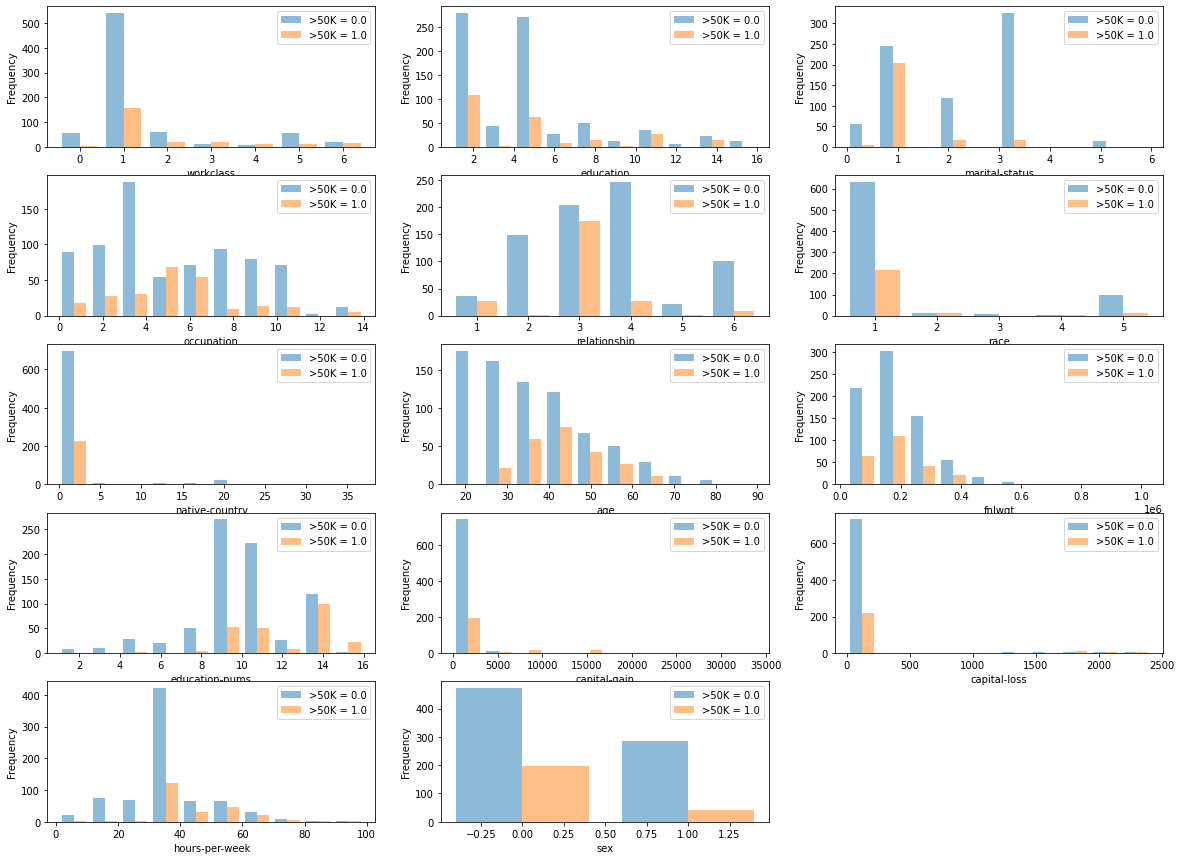

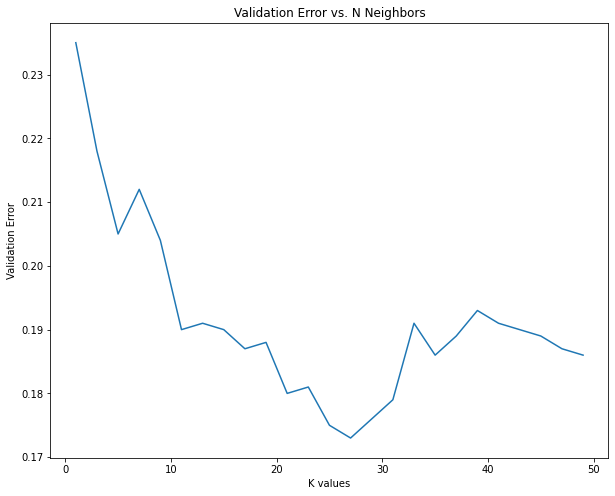

	-- Best k value = 27 Error = 0.173
Investigating depths...


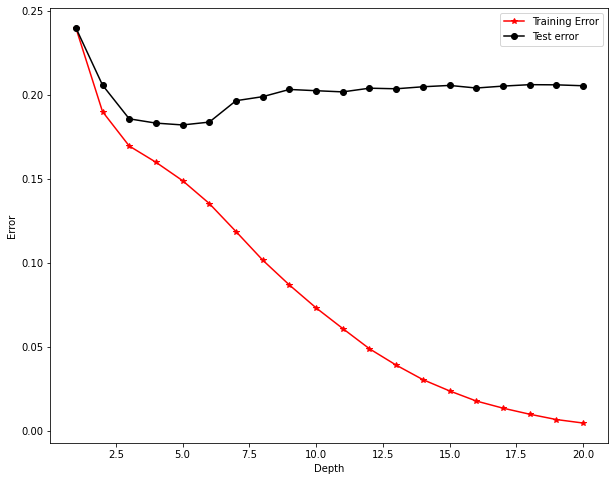

	 -- Best Depth = 5 Test Error = 0.182


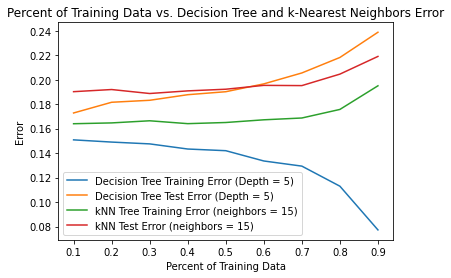

Done


In [36]:
from sklearn.metrics.cluster import entropy

######################################################################
# main
######################################################################

def main():
    
    
    
    # load adult_subsample dataset with correct file path
    ### ========== TODO : START ========== ###
    data_file =  "/content/drive/My Drive/cm146-2023-homeworks/PS1/adult_subsample.csv"
    ### ========== TODO : END ========== ###
    

    data = load_data(data_file, header=1, predict_col=-1)

    X = data.X; Xnames = data.Xnames
    y = data.y; yname = data.yname
    n,d = X.shape  # n = number of examples, d =  number of features

    


    #========================================
    # part a: plot histograms of each feature
    print('Plotting...')
    plot_histograms (X, y, Xnames=Xnames, yname=yname)
    #plt.show()
  


    ### ========== TODO : START ========== ###
    # part i: Preprocess X (e.g., normalize)
    # (try this after finishing the sections below)
    scaler = StandardScaler()
    X = scaler.fit_transform(X)

    ### ========== TODO : END ========== ###




    #========================================
    # train Majority Vote classifier on data
    print('Classifying using Majority Vote...')
    clf = MajorityVoteClassifier() # create MajorityVote classifier, which includes all model parameters
    clf.fit(X, y)                  # fit training data using the classifier
    y_pred = clf.predict(X)        # take the classifier and run it on the training data
    train_error = 1 - metrics.accuracy_score(y, y_pred, normalize=True)
    print('\t-- training error: %.3f' % train_error)





    ### ========== TODO : START ========== ###
    # part b: evaluate training error of Random classifier
    print('Classifying using Random...')
    random_clf = RandomClassifier()
    random_clf.fit(X,y)
    y_pred = random_clf.predict(X)
    train_error = 1 - metrics.accuracy_score(y, y_pred, normalize=True)
    print('\t-- training error: %.3f' % train_error)
    ### ========== TODO : END ========== ###




    ### ========== TODO : START ========== ###
    # part c: evaluate training error of Decision Tree classifier
    print('Classifying using Decision Tree...')
    
    #declare Decision Tree Classifier with "entropy" criterion
    decision_tree_clf = DecisionTreeClassifier(criterion = "entropy")
    decision_tree_clf.fit(X,y)
    y_pred = decision_tree_clf.predict(X)
    train_error = 1 - metrics.accuracy_score(y,y_pred, normalize=True)
    print('\t-- training error: %.3f' % train_error)
    ### ========== TODO : END ========== ###




    ### ========== TODO : START ========== ###
    # part d: evaluate training error of k-Nearest Neighbors classifier
    # use k = 3, 5, 7 for n_neighbors
    print('Classifying using k-Nearest Neighbors...')
    for k in [3,5,7]:
      #Number of neighbors is equal to k = [3,5,7]
      kNN_clf = KNeighborsClassifier(n_neighbors = k)
      kNN_clf.fit(X,y)
      y_pred = kNN_clf.predict(X)
      train_error = 1 - metrics.accuracy_score(y,y_pred, normalize=True)

      #print k = #number of neighbors and training error
      print('\t-- k = %d training error: %.3f' % (k,train_error))

    # print the error for each k


    ### ========== TODO : END ========== ###




    ### ========== TODO : START ========== ###
    # part e: use cross-validation to compute average training and test error of classifiers
    print('Investigating various classifiers...')

    #Setup two arrays for the Classifier object and names of classifiers
    classifiers = [MajorityVoteClassifier(),RandomClassifier(),DecisionTreeClassifier(criterion = "entropy"),KNeighborsClassifier(n_neighbors = 5)]
    name_classifiers = ["Majority","Random","Decision Tree","KNeighbors"] 
    index = 0

    #loop for each classifier and display Training Error,Test Error, and F1 score for each
    for clf in classifiers:

      c_error = error(clf,X,y)
      print('\t-- %s Training Error = %.3f'%(name_classifiers[index],c_error[0]))
      print('\t-- %s Test Error = %.3f'%(name_classifiers[index],c_error[1]))
      print('\t-- %s F1 Score = %.3f'%(name_classifiers[index],c_error[2]))
      index+=1


    # summary = error(clf, X, y, ntrials=20)
    # print(summary)
    ### ========== TODO : END ========== ###




    ### ========== TODO : START ========== ###
    # part f: use 10-fold cross-validation to find the best value of k for k-Nearest Neighbors classifier
    print('Finding the best k...')
    
    #Create list of odd number k values from 1 - 50 with step length 2 k = 1,3,5...49
    k_values = list(range(1,50,2))

    #create classifier for each k value
    
    error_vals = []

    for k in k_values:

      kNN_clf = KNeighborsClassifier(n_neighbors = k)
      k_error = 1 - cross_val_score(kNN_clf, X, y, cv = 10).mean()
      error_vals.append(k_error)

    plt.figure(figsize = (10,8))
    plt.plot(k_values,error_vals)
    plt.xlabel("K values")
    plt.ylabel("Validation Error")
    plt.title("Validation Error vs. N Neighbors")
    plt.show()

    min_error = np.min(error_vals)
    best_k = np.argmin(error_vals)*2+1

    print('\t-- Best k value = %d Error = %.3f' %(best_k, min_error))


    ### ========== TODO : END ========== ###




    ### ========== TODO : START ========== ###
    # part g: investigate decision tree classifier with various depths
    print('Investigating depths...')
    
    tree_depths = list(range(1,21))
    training_error = []
    test_error = []
    max_depth = []

    #calculate Error for each depth in tree_depths from 1 to 20
    for depth in tree_depths:
      dt_clf = DecisionTreeClassifier(max_depth = depth,criterion = "entropy")
      
      dt_error = error(dt_clf,X,y)
      
      training_error.append(dt_error[0])
      test_error.append(dt_error[1])
      max_depth.append(depth)

    
    fig = plt.figure(figsize =(10,8)).add_subplot()
    fig.plot(max_depth,training_error,label = "Training Error", color = "red",marker = "*")
    fig.plot(max_depth,test_error,label = "Test error", color = "black",marker = 'o')
    plt.xlabel("Depth")
    plt.ylabel("Error")
    plt.legend()
    plt.show()


    min_test = np.min(test_error)
    best_depth = np.argmin(test_error)+1
    
    print('\t -- Best Depth = %d Test Error = %.3f' %(best_depth, min_test))


    ### ========== TODO : END ========== ###


    ### ========== TODO : START ========== ###
    # part h: investigate decision tree and k-Nearest Neighbors classifier with various training set sizes
    # hint: use train_test_split (use random_state=0 for consistent results)

    #Setup errors for decision tree and kNN
    dt_train = []
    dt_test = []
    kNN_train = []
    kNN_test = []


    #Create list of percents 0.1,0.2...1.0 
    percent_arr = [x/10.0 for x in range(1,10)]

    strat_split = StratifiedShuffleSplit(n_splits = 1, test_size = 0.1, random_state = 0)
    
    for train_data,test_data in strat_split.split(X,y):
      X_train = X[train_data]
      X_test = X[test_data]
      y_train = y[train_data]
      y_test = y[test_data]

    #Best depth found before was 5
    dt = DecisionTreeClassifier(max_depth = 5, criterion ="entropy")
    dt.fit(X_train,y_train)

    #Best k value found before was 15
    kNN = KNeighborsClassifier(n_neighbors = 15)
    kNN.fit(X_train,y_train)


    #calculate error for each classifier in increments of 0.1
    for percent in percent_arr:

      dt_error = error(dt,X,y,ntrials=100,test_size = percent)
      dt_train.append(dt_error[0])
      dt_test.append(dt_error[1])

      kNN_error = error(kNN,X,y,ntrials=100,test_size = percent)
      kNN_train.append(kNN_error[0])
      kNN_test.append(kNN_error[1])

    dt_train_output = plt.plot(percent_arr,dt_train,label = "Decision Tree Training Error (Depth = 5)")
    dt_test_output = plt.plot(percent_arr,dt_test,label = "Decision Tree Test Error (Depth = 5)")
    kNN_train_output = plt.plot(percent_arr,kNN_train,label = "kNN Tree Training Error (neighbors = 15)")
    kNN_test_output = plt.plot(percent_arr,kNN_test,label = "kNN Test Error (neighbors = 15)")

    output = []
    for plot_output in [dt_train_output, dt_test_output, kNN_train_output, kNN_test_output]:
      output.extend(plot_output)

    plt.xlabel("Percent of Training Data")
    plt.ylabel("Error")
    plt.legend(handles = output)
    plt.title("Percent of Training Data vs. Decision Tree and k-Nearest Neighbors Error")
    plt.show()
    
    
    ### ========== TODO : END ========== ###



    print('Done')


if __name__ == "__main__":
    main()
